# CODECADEMY WALKTHROUGH: BIODIVERSITY IN NATIONAL PARKS

This is my second walkthrough for Codecademy's Data Science career path.\
I am going to explore the *Biodiversity in National Parks* dataset for completing the *data analysis portfolio project*.

## Exploratory Data Analysis
Data are provided by Codecademy as part of the project in two files named `species_info.csv` and `observations.csv`.\
Let's begin, it is time to get acquainted with our dataset!

### Import statements
We start by importing all the relevant packages.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from scipy.stats import chi2_contingency

### Load CSV
We are ready for loading CSV files and assign them to pandas dataframes.\
The first five rows of each table are visible below.

**Note:** *if you look at `observations.csv` you should notice that parks names always end with `'National Park'`.\
When working with seaborn plots this sub-string is annoying as these words take additional space without adding any value.\
It is better to remove them now.*

In [2]:
# Set dataframe column width
df_width = '120px'

# Import infos on species
s_info_df = pd.read_csv('species_info.csv')
display(s_info_df.head().style.set_caption('Infos on Species'))

# Import infos on observations
obs_df = pd.read_csv('observations.csv')
# Remove 'national park' from park name (smaller labels on graphs)
obs_df.park_name = obs_df.park_name.str.replace('national park','', case=False)
display(obs_df.head().style.set_caption('Observations in National Parks'))

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,nan
1,Mammal,Bos bison,"American Bison, Bison",nan
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Domesticated Cattle",nan
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",nan
4,Mammal,Cervus elaphus,Wapiti Or Elk,nan


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains,68
1,Neovison vison,Great Smoky Mountains,77
2,Prunus subcordata,Yosemite,138
3,Abutilon theophrasti,Bryce,84
4,Githopsis specularioides,Great Smoky Mountains,85


We can sort the conservation status based on gravity, for future use.\
The following *conservation statuses* are present in our dataframe.

In [3]:
display(pd.DataFrame({'conservation_status':s_info_df.conservation_status.unique()}))

,conservation_status
0,NaN
1,Species of Concern
2,Endangered
3,Threatened
4,In Recovery


SInce `NaN`values are assigned to species that are **not endangered**, we can replace them with a `'Low Risk'` indication.\
These statuses are then sorted and applied as sorted categoricals (see [endangered, threatened](https://www.usgs.gov/faqs/what-are-differences-between-endangered-threatened-imperiled-and-risk-species?qt-news_science_products=0#qt-news_science_products) and [species of concern](https://www.maine.gov/ifw/fish-wildlife/wildlife/endangered-threatened-species/special-concern.html) for better understand how to sort them).

In [4]:
s_info_df.conservation_status[s_info_df.conservation_status.isna()] = 'Low Risk'
s_info_df.conservation_status = pd.Categorical(s_info_df.conservation_status, 
                                               categories=['Low Risk', 'Species of Concern', 
                                                           'In Recovery', 'Threatened', 'Endangered'], 
                                               ordered=True)

Now that the dataframes are ready for use let's figure out what we have.\
These are the first questions that hit me:
- How many categories are included in this dataset?
- Do we have a lot of species or just a few?
- Wich park are available?
- Which endangered animals are observed frequently?

We can start our journey by answering these simple questions.

### Dataset basic description
By joining `s_info_df` and `obs_df` together in a single dataframe (`join_df`) we can better investigate some connections.\
However it is necessary that the `s_info_df` has unique values for the key we will use for the merging process.\
In our case the index used for merge is the `scientific_name` column: one species can be only in one state (*endangered*, *thretened*, etc.) at a given time.\
A quick check for duplicates is required.

In [5]:
s_duplicates = s_info_df[s_info_df.scientific_name.duplicated(keep=False)]
print(f'Duplicates: {len(s_duplicates)}')

Duplicates: 557


Ok, it make sense to keep only the worst record among the duplicates.\
For example, if a species shows both *threatened* and *endangered* only *endangered* is kept, as this should give us the worst scenario in terms of risk.\
We can drop duplicates from `s_info_df` and keep only the first item.

In [6]:
# Canis lupus example (before) displayed on next code cell
cl_before = s_info_df[s_info_df.scientific_name.str.contains('Canis lupus')].reset_index(drop=True)
cl_before = cl_before.style.set_caption('Canis Lupus duplicates before removal')

# Drop duplicates
s_info_df.drop_duplicates(inplace=True, subset='scientific_name', keep='first')
s_info_df.reset_index(drop=True, inplace=True)

Then we update the relevant records with the worst status available among the duplicates(results for `'Canis Lupus'` are shown before and after the process).\
Finally we have the the call to `merge`.

In [7]:
# Worst cases
worst_cases = s_duplicates.groupby('scientific_name').conservation_status.max()

# Update the status for each duplicate that we kept
for species, worst_risk in worst_cases.iteritems():
    s_info_df.conservation_status[s_info_df.scientific_name == species] = worst_risk

# Canis lupus example (before)
display(cl_before)

# Canis lupus example (after)
cl_after = s_info_df[s_info_df.scientific_name.str.contains('Canis lupus')].reset_index(drop=True)
cl_after = cl_after.style.set_caption('Canis Lupus duplicates after removal')
display(cl_after)

# Join
join_df = s_info_df.merge(obs_df, on='scientific_name', how='outer')
display(join_df.head(5).style
       .set_caption('Join process result (first rows)'))

,category,scientific_name,common_names,conservation_status
0,Mammal,Canis lupus,Gray Wolf,Endangered
1,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
2,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


,category,scientific_name,common_names,conservation_status
0,Mammal,Canis lupus,Gray Wolf,Endangered


,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Bryce,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yellowstone,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Great Smoky Mountains,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,Low Risk,Yosemite,117
4,Mammal,Bos bison,"American Bison, Bison",Low Risk,Yosemite,128


If the merge was done correctly we should end with a dataframe that is as long as the observation dataframe.
This because we choose an `'outer'` join and we expect that all values in the `scientific_name` column are used inside the observations dataframe (`obs_df`).

In [8]:
print(f'Length of s_info_df: \t{len(s_info_df)}')
print(f'Length of obs_df: \t{len(obs_df)}')
print(f'Length of join_df: \t{len(join_df)}')

Length of s_info_df: 	5541
Length of obs_df: 	23296
Length of join_df: 	23296


Well done!\
Now we can answer to exploratory questions.

#### Categories
A simple bar graph describing the number of observations per category will show which categories exist in our dataset. In addition we will get an idea of the most frequent ones.

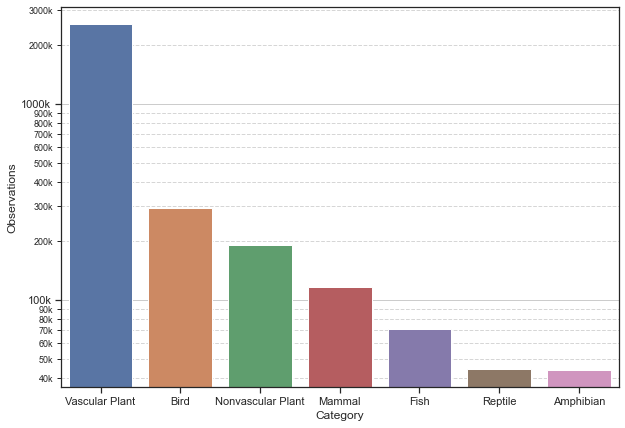

,category,observations
0,Vascular Plant,2555090
1,Bird,292833
2,Nonvascular Plant,190653
3,Mammal,116696
4,Fish,70818
5,Reptile,44678
6,Amphibian,43971


In [9]:
# Theme preferences (used for every plot)
sns.set_theme(style='ticks', rc={'axes.grid': True})

# Create grouped frame with category and observations
obs_and_cat_df = join_df[['category', 'observations']].groupby('category').sum()\
                                                      .sort_values('observations', ascending=False)\
                                                      .reset_index()

# Bar plot
plt.figure(figsize=[10, 7])
sns.barplot(x=obs_and_cat_df.category, y=obs_and_cat_df.observations)
# Labels
plt.xlabel('Category')
plt.ylabel('Observations')
# y axis as thousands of observations
plt.yscale('log')
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_major_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.gca().yaxis.set_minor_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.tick_params(which='minor', labelsize = 9)

plt.show()

# Add table
display(obs_and_cat_df.style.set_properties(width=df_width))

Seven categories are present: if you do not know the difference between [vascular](https://en.wikipedia.org/wiki/Vascular_plant) and [nonvascular](https://en.wikipedia.org/wiki/Non-vascular_plant) plants, take a look at *Wikipedia*.\
We see that *vascular plants* are the clear winner and that *birds* are most frequently spotted animals.

#### Species
The *number of species* is rather high instead: in this case a `barplot` would show a confusing ensamble of bars, rather than a synthetic visualization.

In [10]:
# Create grouped frame with category and observations
unique_species = join_df.scientific_name.unique()
print(f"Unique species in dataset: {len(unique_species)}")

Unique species in dataset: 5541


#### Parks
The same approach used for *categories* is repeated for *parks*.
The difference here is that also *observations shares* in percent are shown.

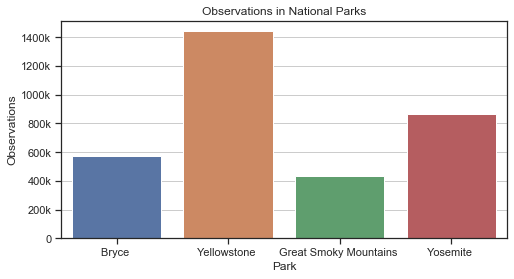

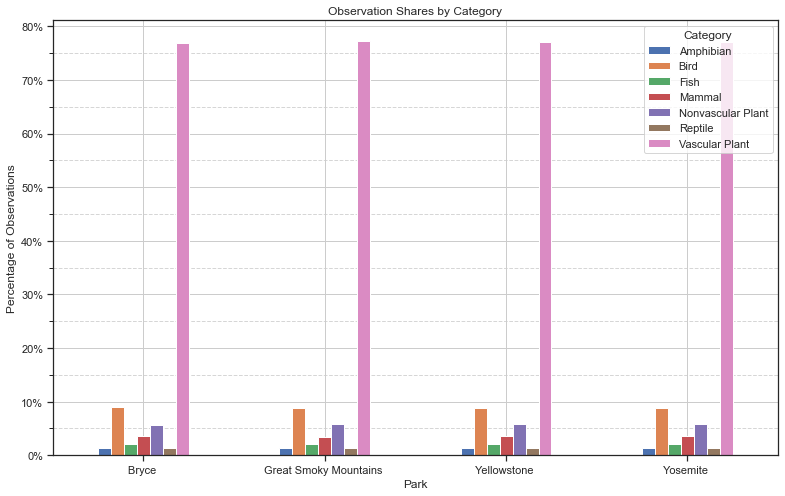

Category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
Park name,,,,,,,
Bryce,1.3%,9.0%,2.2%,3.6%,5.7%,1.4%,76.9%
Great Smoky Mountains,1.3%,8.7%,2.1%,3.5%,5.8%,1.3%,77.3%
Yellowstone,1.3%,8.8%,2.1%,3.5%,5.8%,1.4%,77.1%
Yosemite,1.3%,8.8%,2.2%,3.5%,5.8%,1.3%,77.1%


In [11]:
# Create grouped frame with parks and observations
obs_and_park_df = join_df.pivot_table(index='park_name', columns='category', values='observations', aggfunc=sum)
# Convert value to percentage
obs_and_park_df = obs_and_park_df.apply(lambda x: x/x.sum()*100, axis=1)
# Adjust row/column description
obs_and_park_df.rename_axis('Park name', inplace=True)
obs_and_park_df.rename_axis('Category', axis='columns', inplace=True)

# Bar plot absolute values of observations
plt.figure(figsize=[8, 4])
sns.barplot(data=join_df, x='park_name', y='observations', estimator=sum, ci=None)
# Labels
plt.xlabel('Park')
plt.ylabel('Observations')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_major_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
plt.gca().yaxis.set_minor_formatter(lambda x, pos: '0' if x==0 else '{:.0f}k'.format(x * 1e-3))
# Title
plt.title('Observations in National Parks')

plt.show()

# Bar plot percentages
obs_and_park_df.plot(kind='bar', stacked=False, figsize=[13, 8])
# Labels
plt.xlabel('Park')
plt.ylabel('Percentage of Observations')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}%'.format(x))
plt.xticks(rotation=0)
# Title
plt.title('Observation Shares by Category')

plt.show()

# Add table
display(obs_and_park_df.style
        .format("{:.1f}%")
        .set_caption('Observation percentages'))

There are four parks and *Yellowstone* definitely has the lead in terms of number of observations.\
However it is clear that observations percentages by categories are practically the same (and this is probably a sign that *the dataset is fictional*).

#### Frequent observations of endangered animals
We want to find frequently spotted endangered animals: we can look at the frequence of words in `common_names` column.\
Since we are interested in *species at risk* it is better to create two dedicated dataframes, `endangered_species` and `endangered_obs`, which exclude the `'Low Risk'` label from species informations and observation statuses respectively.\
Repeated names belong to frequently observed animals.

In [12]:
# Create endangered dataframe for both s_info_df and join_df
endangered_species = s_info_df[~ s_info_df.conservation_status.isin(['Low Risk'])].copy()
endangered_obs = join_df[~ join_df.conservation_status.isin(['Low Risk'])].copy()

# Remove low risk from categories
endangered_species.conservation_status = endangered_species.conservation_status.cat.remove_unused_categories()
endangered_obs.conservation_status = endangered_obs.conservation_status.cat.remove_unused_categories()

# Crate a bag of words with all words from common names in observations
bag_words = endangered_obs.common_names.str.replace(',', '').str.split('\s')
# Create a list of words
names_words = []
for index, words in bag_words.iteritems():
    names_words.extend(words)
# Find values count
names_words = pd.Series(names_words, name='word_count')
word_count = names_words.value_counts().to_frame()
# Look at first 20
display(word_count[:20].style.set_caption('Frequent words - top 20'))

,word_count
Myotis,96
Bat,60
Brown,40
California,28
Mountain,28
American,28
Northern,28
Little,24
Snake,16
Wolf,16


Following endangered animals are easier to observe during a visit:
- Bats
- Badgers
- Warbiers
- Wolves
- Snakes
- Sparrows
- Hawks

## Scope of Project
After completing the exploratory analysis, let's define the scope of the project.\
Based on what above we will investigate the following questions:
- Which categories (`Bird`, `Mammal`, etc.) have the highest chance to become at risk an need attention?
- Sparrow and hawks are observed frequently and they belong to the same category (*birds*):\
is the relationship between observations of these species and their risk of extinction statistically significant?
- Which park has more observations of endangered sparrows and hawks?

It looks like we're going to be very commited about birds: let's get ready to fly then!

### Species at risk
After replacing `NaN`values from `s_info_df` (see ["Load CSV"](#Load-CSV) paragraph) we take a closer look to the conservation status.

In [13]:
display(s_info_df.conservation_status.value_counts(dropna=False).to_frame())

,conservation_status
Low Risk,5362
Species of Concern,151
Endangered,15
Threatened,10
In Recovery,3


We notice that **the vast majority of species is not at risk**.\
It is nice to know!\
Now is the turn of endangered species, so we will refer to `endangered_species` and `endangered_obs` (see para. [Frequent observations of endangered animals](#Frequent-observations-of-endangered-animals)).

In [14]:
display(endangered_species.conservation_status.value_counts(dropna=False).to_frame())

,conservation_status
Species of Concern,151
Endangered,15
Threatened,10
In Recovery,3



There are 25 species under threat (either *endangered* or *threatened*) and 3 species under *recovery*.\
All of them need special attentions but maybe we can avoid other species to reach the same condition: **acting in advance is a good idea**.\
151 species in the `endangered_species`dataframe belong to the class *species of concern*, this is a considerable amount!

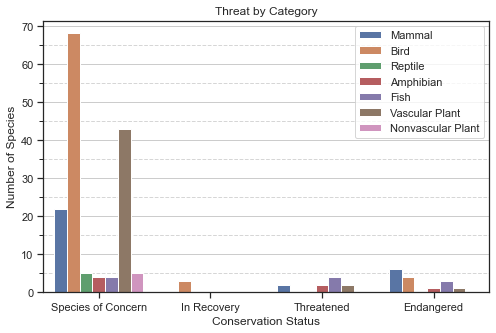

In [15]:
# Countplot
plt.figure(figsize=[8, 5])
sns.countplot(data=endangered_species, 
              x="conservation_status", hue="category")
# Labels
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
# y axis as thousands of observations
plt.grid(b=True, which='minor', linestyle='--', alpha=0.8)
plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
# Title
plt.title('Threat by Category')
# Legend
plt.legend(loc='upper right')

plt.show()

*Species of concern* are the one in need of conservation, therefore **a suggestion for conservationists is to monitor *mammals*, *birds* and *vascular plant*** listed under this class.\
Such categories show the highest numbers of species that are matter of concern: preventive actions may avoid that their condition worsen to an *endangered* or *threatened* state.

### Statistical significance of relationship between sparrows, hawks and conservation status
With regards to observations, is there an association between bird type (*hawk* or *sparrow*) and its conservation status (*low risk* or *species of concern* in this case)?\
We will investigate this by using `chi2_contingency` test from the `scipy` package.

In [16]:
# Isolate Hawks and Sparrows observations (only common_names and conservation status are required)
SP_and_HW = join_df[(join_df.common_names.str.contains('Hawk|Sparrow')) 
                    & (join_df.category == 'Bird')].copy()
SP_and_HW = SP_and_HW[['park_name', 'common_names', 'conservation_status']].reset_index(drop=True)
# Add an Hawk or Sparrow identifier
SP_and_HW['hawk_or_sparrow'] = SP_and_HW.common_names.apply(lambda x: 'Hawk' if 'Hawk' in x else 'Sparrow')
# Display table
display(pd.concat([SP_and_HW.head(), SP_and_HW.tail()]).style
                  .set_caption('Sparrows and hawks observations (first and last rows)'))


# Create a contingency table
contingency_SP_HW = pd.crosstab(SP_and_HW.conservation_status, SP_and_HW.hawk_or_sparrow)
# Adjust row/column description
contingency_SP_HW.rename_axis('Conservation Status', inplace=True)
contingency_SP_HW.rename_axis('Hawk/Sparrow', axis='columns', inplace=True)
display(contingency_SP_HW.style.set_caption('Contingency table'))

# Run chi2 test
chi2, pval, _, expected_f = chi2_contingency(contingency_SP_HW)
alfa = 0.05
result = ('significant' if pval < alfa else 'not significant')

print(f'chi2: {chi2:.2f}')
print(f'p-value: {pval:.3e}')
print(f'Test result: association between variables is {result} (alfa = {alfa})')

,park_name,common_names,conservation_status,hawk_or_sparrow
0,Bryce,Cooper's Hawk,Species of Concern,Hawk
1,Yosemite,Cooper's Hawk,Species of Concern,Hawk
2,Yellowstone,Cooper's Hawk,Species of Concern,Hawk
3,Great Smoky Mountains,Cooper's Hawk,Species of Concern,Hawk
4,Yosemite,Sharp-Shinned Hawk,Species of Concern,Hawk
143,Yosemite,Gambel's White-Crowned Sparrow,Low Risk,Sparrow
144,Great Smoky Mountains,Mountain White-Crowned Sparrow,Low Risk,Sparrow
145,Yellowstone,Mountain White-Crowned Sparrow,Low Risk,Sparrow
146,Bryce,Mountain White-Crowned Sparrow,Low Risk,Sparrow
147,Yosemite,Mountain White-Crowned Sparrow,Low Risk,Sparrow


Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,16,100
Species of Concern,16,16


chi2: 17.32
p-value: 3.151e-05
Test result: association between variables is significant (alfa = 0.05)


According to [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html):
> An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5.

Our minimum frequency in `contingency_SP_HW` is 16, hence this requirement is satisfied for *observed frequencies*.\
What about expected ones?


In [17]:
# Prepare expected frequency dataframe
expected_f_df = contingency_SP_HW.copy()
expected_f_df.iloc[:,:] = expected_f
display(expected_f_df.style
                     .format("{:.1f}")
                     .set_caption('Expected frequencies'))

Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,25.1,90.9
Species of Concern,6.9,25.1


Also *expected frequencies* are above 5, so we can deem the test as valid:\
**there is a relationship between the spotted bird type (*hawk* or *sparrow*) and its conservation status**.

This result means that it is improbable to draw an observations sample like the one we are looking at, from a population where no association exists between bird type (*hawk* / *sparrow*) and *conservation status*.\
When a bird is spotted, it is definitely easier to see a *species of concern* if that bird is an hawk.

Intuitively this make sense, as our database shows a proportion of *species of concern* which is higher for hawks than sparrows.\
In addition there are typically less hawks than sparrows in a stable ecosystem (as we would expect in a *predator/prey relationship*).

In [18]:
# Find info for hawks and sparrows species
SP_and_HW_info = s_info_df[(s_info_df.common_names.str.contains('Hawk|Sparrow')) 
                           & (s_info_df.category == 'Bird')].copy()
# Add an Hawk or Sparrow identifier
SP_and_HW_info['hawk_or_sparrow'] = SP_and_HW_info.common_names.apply(lambda x: 'Hawk' if 'Hawk' in x else 'Sparrow')
# Species of concern vs low risk
contingency_SP_HW_info = pd.crosstab(SP_and_HW_info.conservation_status, SP_and_HW_info.hawk_or_sparrow)
# Adjust row/column description
contingency_SP_HW_info.rename_axis('Conservation Status', inplace=True)
contingency_SP_HW_info.rename_axis('Hawk/Sparrow', axis='columns', inplace=True)
display(contingency_SP_HW_info.style.set_caption('Species vs conservation status'))

Hawk/Sparrow,Hawk,Sparrow
Conservation Status,,
Low Risk,4,24
Species of Concern,4,4


### Best locations for watching rare sparrows and hawks
So what is the best place to look at endangered sparrows or hawks?\
This is a simple one!\
`sns.catplot` draw a *grid of countplots*.

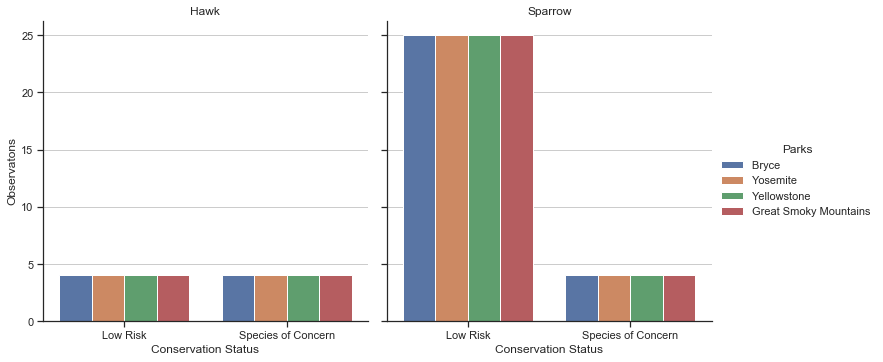

In [19]:
# Remove unused categories to obtain a better plot
SP_and_HW.conservation_status = SP_and_HW.conservation_status.cat.remove_unused_categories()

# Countplot
g = sns.catplot(x='conservation_status', col='hawk_or_sparrow',
                hue='park_name', data=SP_and_HW,
                kind="count", height=5,
                legend=True)

# Improve lables
for ax in g.axes[0,:]:
    ax.set_xlabel('Conservation Status')
g.axes[0,0].set_ylabel('Observatons')
g.axes[0,0].set_title('Hawk')
g.axes[0,1].set_title('Sparrow')
g._legend.set_title('Parks')
plt.show()

Well, it seems that one park is as good as another...\
We already noticed that the dataset seems ficional and this is another argument to support that hypothesis.

## Conclusions
We can finally review our answers:
- It would be useful to monitor *mammals*, *birds* and *vascular plant* listed under the *species of concern* class.\
Taking preventive actions to protect species in need of conservation is safer than having them sitting on the brink of extinction.
- A relationship between observations of hawks and sparrows and their risk of extinction has been found.\
Hawks are rarer to see, but when spotted is easier to see a protected species compared to sparrows.
- This dataset is probably fictional, as a result observations of protected sparrows and hawks are equally distributed among parks.\
Choose the park that inspire you, I bet you would not regret it.

